<a href="https://colab.research.google.com/github/cvaranasi1/NeuralNetworks_in_TensorFlow/blob/master/Week4_Exercise_Course4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
import numpy as np
import csv
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,LSTM, Bidirectional

In [7]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv


--2020-10-05 18:04:08--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.03s   

2020-10-05 18:04:08 (2.28 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



(3650,)
(3650,)


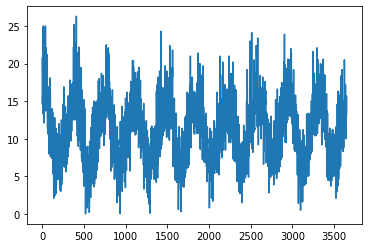

In [8]:
series=[]
with open('/tmp/daily-min-temperatures.csv','r') as f:
  reader = csv.reader(f)
  next(reader)
  for row in reader:
    series.append(float(row[1]))
  series=np.array(series)
  time = np.arange(len(series))
  print(series.shape)
  print(time.shape)
  plt.plot(time,series)
 

In [9]:
pwd

'/content'

In [16]:
split_time = 3000
train_time=time[:split_time]
x_train = series[:split_time]
valid_time=time[split_time:]
x_valid=series[split_time:]
window_size=32
batch_size=1000
shuffle_buffer_size=1000
                

In [17]:
def windowed_dataset(series,batch_size,window_size,shuffle_buffer_size):
  series = tf.expand_dims(series,axis=[-1])
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda window: (window[:-1], window[-1:]))
  return ds.batch(batch_size).prefetch(1)


In [18]:
train_set = windowed_dataset(series,batch_size,window_size,shuffle_buffer_size)

In [21]:
model = Sequential( [Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  Bidirectional(LSTM(64, return_sequences=True)),
  LSTM(64, return_sequences=True),
  Dense(40, activation="relu"),
  Dense(10, activation="relu"),
  Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)])

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
history = model.fit(train_set, epochs=100)


Epoch 1/100
4/4 [==============================] - 2s 492ms/step - loss: 19.4066 - mae: 19.9008
Epoch 2/100
4/4 [==============================] - 2s 492ms/step - loss: 8.1428 - mae: 8.6340
Epoch 3/100
4/4 [==============================] - 2s 497ms/step - loss: 7.9580 - mae: 8.4457
Epoch 4/100
4/4 [==============================] - 2s 492ms/step - loss: 5.9407 - mae: 6.4235
Epoch 5/100
4/4 [==============================] - 2s 492ms/step - loss: 4.9605 - mae: 5.4406
Epoch 6/100
4/4 [==============================] - 2s 490ms/step - loss: 4.2325 - mae: 4.7104
Epoch 7/100
4/4 [==============================] - 2s 488ms/step - loss: 3.3075 - mae: 3.7779
Epoch 8/100
4/4 [==============================] - 2s 493ms/step - loss: 2.9304 - mae: 3.3980
Epoch 9/100
4/4 [==============================] - 2s 486ms/step - loss: 2.5874 - mae: 3.0510
Epoch 10/100
4/4 [==============================] - 2s 490ms/step - loss: 2.4272 - mae: 2.8896
Epoch 11/100
4/4 [==============================] - 2s 49

In [53]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda window:window.batch(window_size+1))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast


In [56]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print(rnn_forecast.shape)
len(rnn_forecast)
len(valid_time)
rnn_forecast = rnn_forecast[split_time - window_size:, -1, 0]
print(rnn_forecast.shape)

(3618, 33, 1)
(650,)


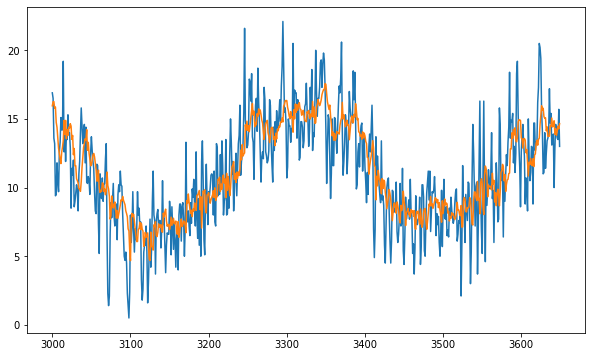

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(valid_time, x_valid)
plt.plot(valid_time, rnn_forecast)